In [14]:
import pandas as pd
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import mape, r2_score, mae
import matplotlib.pyplot as plt
from darts.models import RNNModel, BlockRNNModel, TCNModel
import random
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
)
from darts.dataprocessing import Pipeline
from tqdm.notebook import tqdm


In [15]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    reverted_ts_transformed = scaler.inverse_transform(ts_transformed)
    reverted_pred_series = scaler.inverse_transform(pred_series)
    plt.figure(figsize=(12, 7))
    if start_date:
        reverted_ts_transformed = reverted_ts_transformed.drop_before(start_date)
    reverted_ts_transformed.univariate_component(0).plot(label="actual")
    reverted_pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title("R2: {}".format(r2_score(reverted_ts_transformed, reverted_pred_series)))
    plt.legend()
    print("MAPE: {:.2f}%".format(mape(reverted_ts_transformed, reverted_pred_series)))


In [16]:
def topics_to_series(topics, tot_df):
    series_topics = []
    global scaler
    global filler
    scaler = Scaler(n_jobs=-1, name="Faster")
    filler = MissingValuesFiller(n_jobs=-1, name="Faster")
    for topic in tqdm(topics):
        temp_df = tot_df[tot_df["Topic"] == topic]
        temp_series = TimeSeries.from_dataframe(
            temp_df, "Timestamp", "Frequency", freq="YS"
        )
        temp_series = filler.transform(temp_series, method="quadratic")
        temp_series = scaler.fit_transform(temp_series)
        series_topics.append(temp_series)
    return series_topics


In [17]:
# Uses saved DTM output stored on Drive
topics_over_time = pd.read_csv(
    "output/DTM/collab_dataset_07_22__220000_DTM_collab_custom_default_custom_10_(1, 2)_700.csv"
)


In [18]:
grouped_tot = topics_over_time.groupby(by="Topic").count().reset_index()
outlier_topics = grouped_tot[grouped_tot["Frequency"] < 6]["Topic"].unique()


In [19]:
topics_over_time = topics_over_time[~(topics_over_time["Topic"].isin(outlier_topics))]


In [20]:
topics = set(topics_over_time["Topic"].unique())

training_topics = random.sample(topics, int(len(topics) * 9 / 10))
training_series = topics_to_series(training_topics, topics_over_time)

test_topics = list(topics.difference(set(training_topics)))
testing_series = topics_to_series(training_topics, topics_over_time)


/var/folders/5x/9y9ymrzn2196tkg_ld6m3w280000gn/T/ipykernel_6845/3277874845.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  training_topics = random.sample(topics, int(len(topics) * 9 / 10))


  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

In [21]:
model = NBEATSModel(
    input_chunk_length=3,
    output_chunk_length=3,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    model_name="nbeats_run"
)
model.fit(training_series)


[2022-03-29 22:09:24,739] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 5920 samples.
[2022-03-29 22:09:24,739] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 5920 samples.
[2022-03-29 22:09:24,772] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-29 22:09:24,772] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | stacks    | ModuleList | 8.0 M 
-----------------------------------------
7.9 M     Trainable params
2.6 K     Non-trainable params
8.0 M     Total params
63.615    Total estimated model params size (MB)


Epoch 99: 100%|██████████| 185/185 [07:09<00:00,  2.32s/it, loss=0.107, train_loss=0.102] 


In [22]:
test_topic = 43

In [23]:
topics_over_time[topics_over_time['Topic'] == training_topics[test_topic]]

,Unnamed: 0,Topic,Words,Frequency,Timestamp,Name
118,120,178,"equipment, rental, rental fleet, fleet, equipm...",1,2007-01-01,178_equipment_rental_snow_ice control
939,970,178,"equipment, rental, pratt, rental fleet, parts",2,2009-01-01,178_equipment_rental_snow_ice control
1440,1494,178,"equipment, rental, cranes, fleet, equipment re...",3,2010-01-01,178_equipment_rental_snow_ice control
1955,2032,178,"snow, ice control, snow ice, snowfall, equipment",1,2011-01-01,178_equipment_rental_snow_ice control
2485,2585,178,"ice control, snow ice, snow, snowfall, equipment",1,2012-01-01,178_equipment_rental_snow_ice control
2999,3125,178,"work truck, truck, equipment, snow, ice control",2,2013-01-01,178_equipment_rental_snow_ice control
3546,3699,178,"equipment, rental, rental fleet, equipment sal...",1,2014-01-01,178_equipment_rental_snow_ice control
4128,4312,178,"cranes, equipment, snow, ice control, snow ice",3,2015-01-01,178_equipment_rental_snow_ice control
4706,4922,178,"equipment, rental, cranes, snow, work truck",3,2016-01-01,178_equipment_rental_snow_ice control
5296,5542,178,"equipment, snow, truck, rental, ice control",3,2017-01-01,178_equipment_rental_snow_ice control


  0%|          | 0/6 [00:00<?, ?it/s]

Predicting: 185it [00:00, ?it/s]
Predicting: 185it [00:00, ?it/s]
Predicting: 185it [00:00, ?it/s]
Predicting: 185it [00:00, ?it/s]
Predicting: 185it [00:00, ?it/s]
Predicting: 185it [00:00, ?it/s]
MAPE: 19.41%


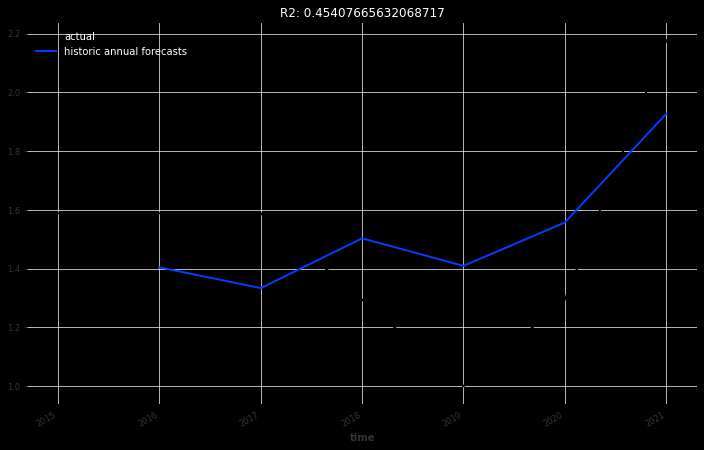

In [24]:
pred_series = model.historical_forecasts(
    training_series[test_topic],
    start=pd.Timestamp("2014-01-01"),
    forecast_horizon=3,
    retrain=False,
    verbose=True,
)

display_forecast(
    pred_series,
    training_series[test_topic],
    "annual",
    start_date=pd.Timestamp("2014-01-01"),
)


In [26]:
model.save_model('models/nbeats_forecasting_model.pth.tar')

  0%|          | 0/6 [00:00<?, ?it/s]

Predicting: 185it [00:00, ?it/s]
Predicting: 185it [00:00, ?it/s]
Predicting: 185it [00:00, ?it/s]
Predicting: 185it [00:00, ?it/s]
Predicting: 185it [00:00, ?it/s]
Predicting: 185it [00:00, ?it/s]
MAPE: 19.41%


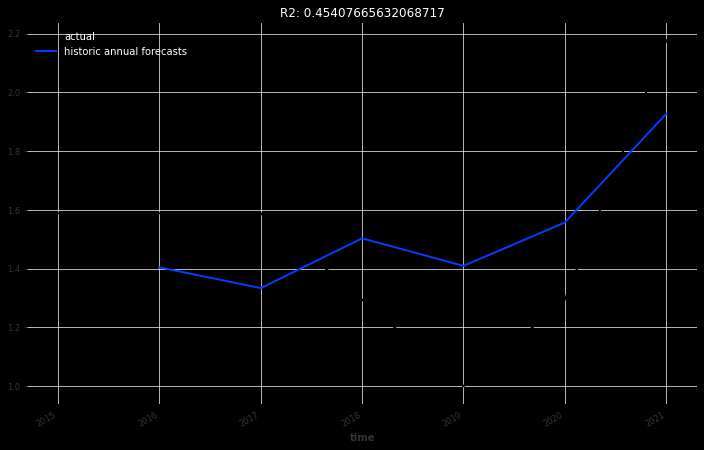

In [27]:
pred_series = model.historical_forecasts(
    testing_series[test_topic],
    start=pd.Timestamp("2014-01-01"),
    forecast_horizon=3,
    retrain=False,
    verbose=True,
)

display_forecast(
    pred_series,
    testing_series[test_topic],
    "annual",
    start_date=pd.Timestamp("2014-01-01"),
)
